In [1]:
import pandas as pd


In [2]:
import numpy as np
data = pd.read_csv('/content/consolidated.csv',encoding="ISO-8859-1")
data

,Date,1,2,3,4,5,6,7,8,9,10,11,12,Label,Pct_inc,Bin_label,Up,Down
0,08-09-1998,Boeing gets Varig order,Airbus gets Emirates order,Dow set for early takeoff,CNNfn market movers,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Inc,1.936619718,Up,1,0
1,09-09-1998,UPS flies with Airbus,Boeing Airbus split order,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Dec,-2.590673575,Down,0,1
2,05-10-1998,Boeing boosts output,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Inc,2.111324376,Up,1,0
3,07-10-1998,Raytheon cuts 14000 jobs,Open skies' at an impasse,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Dec,-2.466793169,Down,0,1
4,08-10-1998,Wall Street struggles in pain,Selling pressure eases,Wall Street reels in pain,Wall St. shaken up,More turmoil for U.S. stocks,Yen takes second bite of bond,NaN,NaN,NaN,NaN,NaN,NaN,Dec,-2.946954813,Down,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6073,17-02-2017,Trump and jobs: A running fact check,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Inc,0.784543054,Up,1,0
6074,21-02-2017,Move over Amazon: Here comes Walmart,Retailers report; Central bank chatter; Stock ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Inc,0.337028512,Up,1,0
6075,22-02-2017,These 10 stocks dominate the market,How Trump could make the trade deficit look worse,Amazon brings free shipping minimum back down ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Dec,-0.747406228,Down,0,1
6076,23-02-2017,Fallen angels? Victoria's Secret sales plunge,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Dec,-0.958336111,Down,0,1


In [3]:
data.fillna('',inplace = True)
data

,Date,1,2,3,4,5,6,7,8,9,10,11,12,Label,Pct_inc,Bin_label,Up,Down
0,08-09-1998,Boeing gets Varig order,Airbus gets Emirates order,Dow set for early takeoff,CNNfn market movers,,,,,,,,,Inc,1.936619718,Up,1,0
1,09-09-1998,UPS flies with Airbus,Boeing Airbus split order,,,,,,,,,,,Dec,-2.590673575,Down,0,1
2,05-10-1998,Boeing boosts output,,,,,,,,,,,,Inc,2.111324376,Up,1,0
3,07-10-1998,Raytheon cuts 14000 jobs,Open skies' at an impasse,,,,,,,,,,,Dec,-2.466793169,Down,0,1
4,08-10-1998,Wall Street struggles in pain,Selling pressure eases,Wall Street reels in pain,Wall St. shaken up,More turmoil for U.S. stocks,Yen takes second bite of bond,,,,,,,Dec,-2.946954813,Down,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6073,17-02-2017,Trump and jobs: A running fact check,,,,,,,,,,,,Inc,0.784543054,Up,1,0
6074,21-02-2017,Move over Amazon: Here comes Walmart,Retailers report; Central bank chatter; Stock ...,,,,,,,,,,,Inc,0.337028512,Up,1,0
6075,22-02-2017,These 10 stocks dominate the market,How Trump could make the trade deficit look worse,Amazon brings free shipping minimum back down ...,,,,,,,,,,Dec,-0.747406228,Down,0,1
6076,23-02-2017,Fallen angels? Victoria's Secret sales plunge,,,,,,,,,,,,Dec,-0.958336111,Down,0,1


In [4]:
X = []
for i in range(0,len(data)):
    arr = [x.strip() for x in list(data.iloc[i,np.arange(1,13)])]
    arr2 = [x+'.' if not (x.endswith('.') or x.endswith('?') or x.endswith('!')) and not x=='' else x for x in arr]
    s = ' '.join(arr2)
    X.append(s.strip())
df = pd.DataFrame()
df['1'] = X
df['Bin_label'] = data.Bin_label.values
df

,1,Bin_label
0,Boeing gets Varig order. Airbus gets Emirates ...,Up
1,UPS flies with Airbus. Boeing Airbus split or...,Down
2,Boeing boosts output.,Up
3,Raytheon cuts 14000 jobs. Open skies' at an im...,Down
4,Wall Street struggles in pain. Selling pressur...,Down
...,...,...
6073,Trump and jobs: A running fact check.,Up
6074,Move over Amazon: Here comes Walmart. Retailer...,Up
6075,These 10 stocks dominate the market. How Trump...,Down
6076,Fallen angels? Victoria's Secret sales plunge.,Down


### Method 1 (3-class with logistic regression and SpaCy)

In [5]:
import string
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English
import spacy

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, data.Label.values, test_size=0.1)

In [7]:
# Creating list of punctuation marks
punctuations = string.punctuation

# Creating list of stopwords
parser = spacy.load('en_core_web_sm')
stop_words = spacy.lang.en.stop_words.STOP_WORDS


# Creating tokenizer function
def spacy_tokenizer(sentence):
    # Creating token object
    mytokens = parser(sentence)
    
    # Lemmatizing each token and converting each token into lowercase
    # -PRON- represents pronoun. If the lemma of a word is a pronoun, it is represented as '-PRON-'
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]
    
    # Removing stop words
    mytokens = [ word for word in mytokens if word not in stop_words and word not in punctuations ]
    
    # return preprocessed list of tokens
    return mytokens

In [8]:
from sklearn.feature_extraction.text import CountVectorizer
bow_vector = CountVectorizer(tokenizer = spacy_tokenizer, ngram_range=(2,2))

In [9]:
# Custom transformer using spaCy
from sklearn.linear_model import LogisticRegression
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
class predictors(TransformerMixin):
    def transform(self, X, **transform_params):
        # Cleaning Text
        return [clean_text(text) for text in X]

    def fit(self, X, y=None, **fit_params):
        return self

    def get_params(self, deep=True):
        return {}

# Basic function to clean the text
def clean_text(text):
    # Removing spaces and converting text into lowercase
    return text.strip().lower()

from time import time 

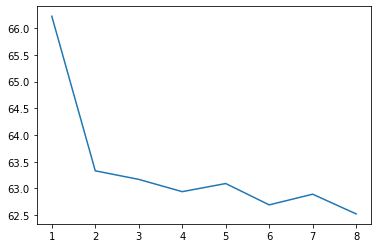

In [10]:
#classifier = LogisticRegression(multi_class='multinomial', solver='lbfgs')
from xgboost import XGBClassifier
from matplotlib import pyplot
t=[1,2,3,4,5,6,7,8]
results=[]
for i in t:
  t1 = time()

  classifier = XGBClassifier(nthread=i)
  # Create pipeline using Bag of Words
  pipe = Pipeline([("cleaner", predictors()),
                  ('vectorizer', bow_vector),
                  ('classifier', classifier)])

  # model generation
  pipe.fit(X_train,y_train)

  t2=time()
  results.append(t2-t1)

pyplot.plot(t, results)
pyplot.show()

In [11]:
from sklearn import metrics
# Predicting with a test dataset
predicted = pipe.predict(X_test)

# Model Accuracy
print("Logistic Regression Accuracy:",metrics.accuracy_score(y_test, predicted))
print("Logistic Regression Precision:",metrics.precision_score(y_test, predicted,average = None))
print("Logistic Regression Recall:",metrics.recall_score(y_test, predicted,average=None))

Logistic Regression Accuracy: 0.4654605263157895
Logistic Regression Precision: [0.42592593 0.47222222 0.35714286]
Logistic Regression Recall: [0.1127451  0.91397849 0.04      ]


### Method 2 (2-class logistic regression and SpaCy)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, data.Bin_label.values, test_size=0.1)

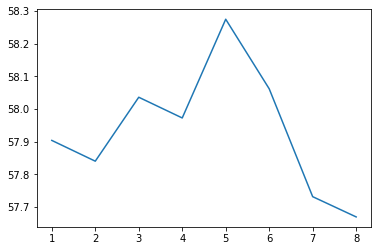

In [13]:
from time import time
from xgboost import XGBClassifier
t=[1,2,3,4,5,6,7,8]
results=[]
for i in t:
  t1 = time()

  classifier = XGBClassifier(nthread=i)
  # Create pipeline using Bag of Words
  pipe = Pipeline([("cleaner", predictors()),
                  ('vectorizer', bow_vector),
                  ('classifier', classifier)])

  # model generation
  pipe.fit(X_train,y_train)

  t2=time()
  results.append(t2-t1)

pyplot.plot(t, results)
pyplot.show()

In [14]:
predicted = pipe.predict(X_test)

# Model Accuracy
print("Logistic Regression Accuracy:",metrics.accuracy_score(y_test, predicted))
print("Logistic Regression Precision:",metrics.precision_score(y_test, predicted,average = "micro"))
print("Logistic Regression Recall:",metrics.recall_score(y_test, predicted,average="micro"))

Logistic Regression Accuracy: 0.48848684210526316
Logistic Regression Precision: 0.48848684210526316
Logistic Regression Recall: 0.48848684210526316


In [15]:
[[y_test[i],predicted[i]] for i in range(len(predicted))]

[['Up', 'Down'],
 ['Up', 'Down'],
 ['Down', 'Down'],
 ['Up', 'Down'],
 ['Down', 'Down'],
 ['Up', 'Down'],
 ['Up', 'Down'],
 ['Down', 'Down'],
 ['Up', 'Down'],
 ['Up', 'Down'],
 ['Down', 'Down'],
 ['Up', 'Up'],
 ['Down', 'Down'],
 ['Down', 'Down'],
 ['Down', 'Down'],
 ['Down', 'Down'],
 ['Up', 'Down'],
 ['Up', 'Down'],
 ['Down', 'Down'],
 ['Down', 'Down'],
 ['Down', 'Down'],
 ['Down', 'Down'],
 ['Down', 'Down'],
 ['Down', 'Down'],
 ['Down', 'Down'],
 ['Up', 'Down'],
 ['Up', 'Down'],
 ['Down', 'Down'],
 ['Down', 'Down'],
 ['Up', 'Down'],
 ['Up', 'Down'],
 ['Down', 'Down'],
 ['Down', 'Down'],
 ['Down', 'Down'],
 ['Down', 'Down'],
 ['Down', 'Down'],
 ['Down', 'Down'],
 ['Down', 'Down'],
 ['Down', 'Down'],
 ['Down', 'Down'],
 ['Up', 'Down'],
 ['Down', 'Up'],
 ['Down', 'Down'],
 ['Down', 'Down'],
 ['Up', 'Down'],
 ['Up', 'Down'],
 ['Down', 'Down'],
 ['Down', 'Down'],
 ['Down', 'Down'],
 ['Up', 'Down'],
 ['Up', 'Down'],
 ['Down', 'Down'],
 ['Up', 'Up'],
 ['Down', 'Down'],
 ['Down', 'Down'],
 

### Method 3: Perceptron and SpaCy

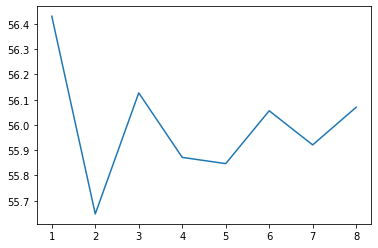

In [16]:
from time import time

from sklearn.linear_model import Perceptron
from sklearn.multiclass import OneVsOneClassifier
# define model
results=[]
cores = [1,2,3,4,5,6,7,8]
for i in cores:
  t1=time()
  model = Perceptron(n_jobs=i)
  classifier = OneVsOneClassifier(model)
  # fit
  pipe = Pipeline([("cleaner", predictors()),
                  ('vectorizer', bow_vector),
                  ('classifier', classifier)])

  # model generation
  pipe.fit(X_train,y_train)
  predicted = pipe.predict(X_test)
  t2=time()
  results.append(t2-t1)
pyplot.plot(cores, results)
pyplot.show()

In [17]:
# Model Accuracy
from sklearn.metrics import accuracy_score
score = accuracy_score(y_test,predicted)
print(score)


0.5213815789473685
